In [1]:
import pandas as pd
import numpy as np
import os

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

from scipy.optimize import curve_fit


In [2]:
def extract_ts_fn():
    brew_data_df = pd.read_csv(os.path.join('data', 'brew_data_with_label.csv'),parse_dates=['createdAt'])
    #brew_data_df = brew_data_df.drop(columns=['temperature', 'grind', 'note'])

    filtered_time_series = []

    for id_,ex in brew_data_df.iterrows():
        data= ex['brew data'].split(';')
        data_num = [float(d) for d in data[:-1]]

        start_date = ex['createdAt']

        freq= "S"
        if len(data) < 5000:
            freq= "3S"
        elif (len(data)>5000) and (len(data)< 10000):
            freq= "2S"

        ts_index = start_date + pd.timedelta_range(0, periods=len(data)-1, freq=freq)
        ts= pd.Series(data_num, index=ts_index)

        ts_parts= seasonal_decompose(ts, model='additive', period=60)
        ts= ts_parts.trend.fillna(0)
        
        initial_timestamp = None
        new_index =[]
        for t, v in ts.iteritems():
            if initial_timestamp is not None:
                new_index.append((t-initial_timestamp).seconds)
            else:
                initial_timestamp= t
                new_index.append(0)
        ts = ts.reset_index()
        ts.index= new_index
        ts = ts.drop(columns=['index'])
        
        filtered_time_series.append(ts)
    return filtered_time_series, brew_data_df['cluster'].to_frame()

In [3]:
def get_increment_points_fn(ts):
    for t, v in ts.iteritems():
        if prev_t is None:
            prev_t = t
            prev_value= v
        elif ((v - prev_value)>10):
            n_items += 1
            prev_value= v
            if (t-prev_t).seconds > 300:
                n_usages +=1
                prev_t= t
    return n_usages, n_items

In [4]:
time_series, labels= extract_ts_fn()

In [5]:
labels.head()

,cluster
0,1
1,1
2,1
3,1
4,1


In [6]:
print(len(time_series))

176


In [7]:
def calculate_increment_points_fn(time_series, increment_thres=5):
    ips = {}
    for i in range(0,len(time_series)):
        ts = time_series[i][:time_series[i].idxmax()['trend']]['trend']
        increment_points = [(0,0)]
        prev_increment_val = 0
        last_increment_val = 0
        last_increment_t = 0
        for t, v in ts.iteritems():
            if v > last_increment_val:
                last_increment_val = v
                last_increment_t = t
            else:
                if ((t-last_increment_t) > 200) and (last_increment_val-prev_increment_val)> increment_thres:
                    increment_points.append((last_increment_t, last_increment_val))
                    prev_increment_val = v

        if (last_increment_val-prev_increment_val)>increment_thres:
                    increment_points.append((last_increment_t, last_increment_val))            

        increment_points_df = pd.DataFrame.from_records(increment_points, columns='index values'.split()).set_index('index')
        #print(increment_points_df)
        #ax=ts.plot();
        #increment_points_df['values'].plot(ax=ax, color='red');
        ips[i]=increment_points_df.drop_duplicates()
    return ips

In [8]:
inc_points = calculate_increment_points_fn(time_series)

In [9]:
inc_points

{0:           values
 index           
 0       0.000000
 4529   22.901667
 8741   49.827500
 16996  85.872500,
 1:            values
 index            
 0        0.000000
 924     21.098333
 2534    46.823333
 4550    63.700000
 11581  115.167500,
 2:           values
 index           
 0       0.000000
 3138   48.606667,
 3:            values
 index            
 0        0.000000
 2258    39.429167
 9982    73.058333
 10988   98.119167
 12972  118.336667,
 4:           values
 index           
 0       0.000000
 3184   76.604167,
 5:           values
 index           
 0       0.000000
 1076   53.629167,
 6:            values
 index            
 0        0.000000
 2468    49.713333
 7738   125.783333
 10984  166.992500
 13460  192.000000,
 7:            values
 index            
 0        0.000000
 2468    49.713333
 7738   125.783333
 10984  166.992500
 13460  192.000000,
 8:         values
 index         
 0       0.0000
 8087   43.0525
 9833   82.8375,
 9:           values
 index 

In [10]:
def fitfunc(x,p1,p2):
    y = p1+(x*p2)
    return y

def make_predictions_fn(inc_points):
    residuals = []
    predictions = {}
    lags = {}

    for i in range(len(inc_points)):
        ic= inc_points[i]

        if len(ic) > 3:

            target = ic[-1:]

            inputs = inc_points[i][:-1]    
            X = inputs.index.values
            Y= inputs['values'].values

            for j in range(2,len(X)+1):
                x = X[:j]
                y = Y[:j]

                popt, pcov = curve_fit(fitfunc, x, y)

                t = 1
                yhat = fitfunc(x[-1]+t, *popt)
                

                predictions_x = [x[-1]+t]
                predictions_y = [yhat]
                while yhat < target['values'].iloc[0]:
                    t+=1
                    yhat = fitfunc(x[-1]+t, *popt)
                    predictions_x.append(x[-1]+t)
                    predictions_y.append(yhat)
                                        
                
                residual = abs(target.index[0] - (predictions_x[-1]))
                residuals.append((i,target.index[0]-x[-1],residual, labels.loc[i,'cluster']))
                #print(i,target.index[0]-x[-1],target.index[0], x[-1],residual)
                
                pred = predictions.get(i,{})
                pred[j]= np.vstack((predictions_x, predictions_y))
                predictions[i]= pred
                
                lag = lags.get(i,{})
                lag[j]= np.vstack((x, y))
                lags[i]= lag
                
                
    residuals_df = pd.DataFrame.from_records(residuals,columns='id pred_horizon error cluster'.split()).set_index('id')
    return residuals_df, predictions, lags

In [11]:
res, pred, lag = make_predictions_fn(inc_points)
res=res[res['error']<5000] #remove outliers

C:\Users\ucam\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [12]:
res.head()

,pred_horizon,error,cluster
id,,,
0,12467,13,1
0,8255,1745,1
1,7031,3604,1
3,2990,3436,1
3,1984,1671,1


In [13]:
res['error'].describe()

count     217.000000
mean     2167.870968
std      1390.177664
min        13.000000
25%      1030.000000
50%      1952.000000
75%      3319.000000
max      4980.000000
Name: error, dtype: float64

In [14]:
res.corr()

,pred_horizon,error,cluster
pred_horizon,1.000000,0.335176,0.156324
error,0.335176,1.000000,0.173113
cluster,0.156324,0.173113,1.000000


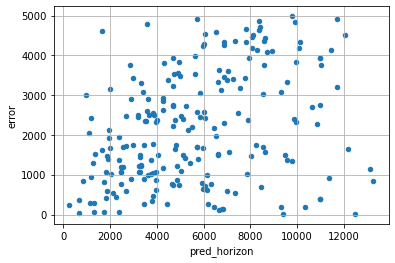

In [15]:
res.plot.scatter(x='pred_horizon',y='error', grid=True);

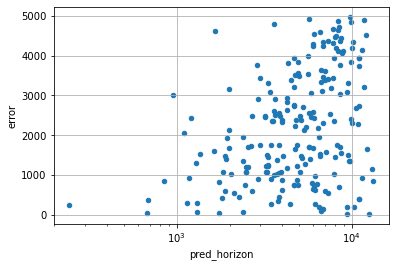

In [16]:
res.plot.scatter(x='pred_horizon',y='error', grid=True, logx=True);

## Error by prediction horizon

In [17]:
res_grouped_df=res.groupby(pd.cut(res["pred_horizon"], np.arange(0, 16000, 2000))).mean()
std_df= res.groupby(pd.cut(res["pred_horizon"], np.arange(0, 16000, 2000))).std()

res_grouped_df['std']= std_df['error']
res_grouped_df = res_grouped_df.drop(columns='pred_horizon'.split())

In [18]:
res_grouped_df

,error,cluster,std
pred_horizon,,,
"(0, 2000]",1320.384615,0.461538,1115.772381
"(2000, 4000]",1649.188679,0.622642,995.885150
"(4000, 6000]",2339.100000,0.540000,1133.365698
"(6000, 8000]",2366.684211,0.763158,1537.230734
"(8000, 10000]",3054.466667,0.833333,1546.821117
"(10000, 12000]",2800.066667,0.866667,1610.906066
"(12000, 14000]",1633.400000,0.600000,1713.584343


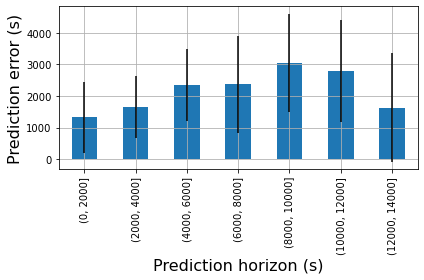

In [19]:
ax=res_grouped_df['error'].plot(kind='bar', yerr=res_grouped_df['std'],grid=True, legend=False);
ax.set_xlabel('Prediction horizon (s)',fontsize=16)
ax.set_ylabel('Prediction error (s)',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join('figs','error_evol.png'))

### Error by cluster

In [20]:
res.groupby('cluster').mean()['error']

cluster
0    2138.009709
1    1817.813953
2    3352.892857
Name: error, dtype: float64

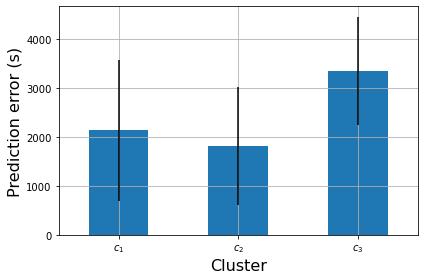

In [21]:
std = res.groupby('cluster').std()['error']
ax=res.groupby('cluster').mean()['error'].plot(kind='bar', yerr=std, grid=True, rot=0)
ax.set_xlabel('Cluster',fontsize=16)
ax.set_ylabel('Prediction error (s)',fontsize=16)
ax.set_xticklabels(['$c_1$','$c_2$','$c_3$'])
plt.tight_layout()
plt.savefig(os.path.join('figs','error_for_cluster.png'))

In [22]:
def plot_predicton_fn(ts, pred, lags):
        
        for k, v in pred.items(): 
            ax=ts.plot(label='Filtered time series')
            ax.set_xlabel('Time (s)', fontsize=16)
            ax.set_ylabel('Bin weight (g)', fontsize=16)
            
            plt.plot(v[0], v[1], 'g--', label=f"Prediction line", linewidth=2)
            plt.plot(lags[k][0], lags[k][1], label=f"Regression Line with {k} lags", linewidth=2)

            plt.plot(lags[k][0], lags[k][1], 'bs')
            plt.text(0, 5, r'$mw_0$')
            plt.text(3700, 29, r'$mw_{4200}$')
            #plt.text(7800, 55, r'$mw_{8000}$')

            plt.hlines(ts.max(),ts.index[0],ts.index[-1], linestyles='dotted', colors='red')

            plt.grid()
            plt.legend(loc='lower right')
            
            plt.savefig(os.path.join('figs',f'prediction_{i}_{k}'))
        #plt.grid()
        #

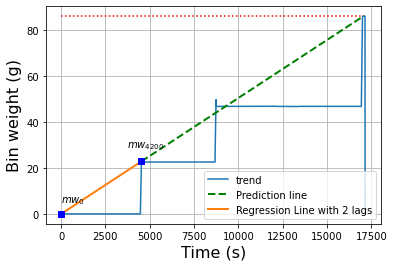

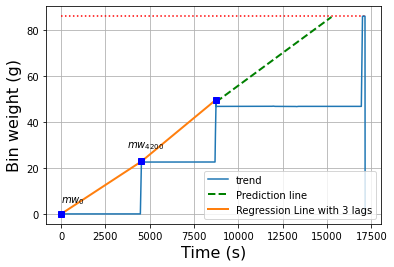

In [23]:
i=0
plot_predicton_fn(time_series[i], pred[i], lag[i])

## Prepare dataframe for route planing
*See notebook 03*

In [24]:
brew_data_df = pd.read_csv(os.path.join('data', 'brew_data_with_label.csv'),parse_dates=['createdAt'], index_col=0)
brew_data_df.head()

,id,name,createdAt,tasty,total time,average flowrate,total weight,brew data,cluster
0,7aLdTgeEWX,157,2021-01-30 19:12:38,4,2535,36.53,109.599998,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,1
1,svIHr0vdP4,156,2021-01-30 18:13:01,4,3373,92.67,278.000000,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,1
2,AT6LzAnzgJ,155,2021-01-30 18:03:08,4,361,7.07,49.500000,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,1
3,wDscJtnyMU,154,2021-01-29 19:14:18,4,1260,17.46,122.199997,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,1
4,FomU4RCCc5,153,2021-01-29 18:05:35,4,1659,26.57,79.699997,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,1


In [25]:
pred

{0: {2: array([[ 4530.        ,  4531.        ,  4532.        , ...,
          16981.        , 16982.        , 16983.        ],
         [   22.90672334,    22.91178001,    22.91683668, ...,
             85.86734415,    85.87240082,    85.8774575 ]]),
  3: array([[ 8742.        ,  8743.        ,  8744.        , ...,
          15249.        , 15250.        , 15251.        ],
         [   48.82652065,    48.83221302,    48.8379054 , ...,
             85.86679715,    85.87248952,    85.8781819 ]])},
 1: {2: array([[ 925.        ,  926.        ,  927.        , ..., 5042.        ,
          5043.        , 5044.        ],
         [  21.12116703,   21.14400072,   21.16683442, ...,  115.12748557,
           115.15031926,  115.17315296]]),
  3: array([[2535.        , 2536.        , 2537.        , ..., 6236.        ,
          6237.        , 6238.        ],
         [  47.79656413,   47.81476235,   47.83296057, ...,  115.14818293,
           115.16638116,  115.18457938]]),
  4: array([[4551.   

In [31]:
def generate_data_for_planner_df(pred, labels):
    data = {}
    for id_, values in pred.items():
        init_date = brew_data_df.loc[id_]['createdAt']
        for inc, inc_values in values.items():
            t_pred= inc_values[0][-1]
            
            pred_date = init_date + timedelta(0,t_pred) 

            t_real = int(time_series[id_].idxmax().values[0])
            real_date = init_date + timedelta(0,t_real)
            day = real_date.strftime("%d/%m/%Y")

            interval_for_planner = (pred_date.hour-1, pred_date.hour)
            if pred_date.hour== 0:
                interval_for_planner = (23, 24)
                
            max_hour = real_date.hour
            
            cluster = labels.loc[id_]['cluster']
            
            l = data.get(inc,[])
            l.append((id_, cluster, day, inc, pred_date,real_date,interval_for_planner, max_hour, None))
            data[inc]= l
            
        #print(id_,values)
    dfs = {}
    for id_, d in data.items():
        dfs[id_] = pd.DataFrame.from_records(d, columns='id cluster day num_increments pred_date real_date interval_for_planner max_hour success'.split())
    
    return dfs

In [32]:
data_for_planner = generate_data_for_planner_df(pred, labels)

In [33]:
data_for_planner[6].head(200)

,id,cluster,day,num_increments,pred_date,real_date,interval_for_planner,max_hour,success
0,12,0,28/01/2021,6,2021-01-28 19:11:41,2021-01-28 19:52:43,"(18, 19)",19,None
1,83,0,15/01/2021,6,2021-01-15 19:53:56,2021-01-15 20:15:27,"(18, 19)",20,None
2,91,0,14/01/2021,6,2021-01-14 22:06:31,2021-01-14 21:56:29,"(21, 22)",21,None
3,104,2,13/01/2021,6,2021-01-13 22:28:20,2021-01-13 23:00:34,"(21, 22)",23,None
4,107,0,13/01/2021,6,2021-01-13 19:21:40,2021-01-13 20:16:05,"(18, 19)",20,None
5,108,0,13/01/2021,6,2021-01-13 19:07:38,2021-01-13 18:55:49,"(18, 19)",18,None
6,119,0,12/01/2021,6,2021-01-12 15:34:54,2021-01-12 15:35:50,"(14, 15)",15,None
7,121,2,12/01/2021,6,2021-01-12 02:00:44,2021-01-12 02:42:16,"(1, 2)",2,None
8,123,0,12/01/2021,6,2021-01-12 01:11:15,2021-01-12 01:36:02,"(0, 1)",1,None
9,127,2,11/01/2021,6,2021-01-11 21:02:46,2021-01-11 21:59:16,"(20, 21)",21,None


In [34]:
for inc, df  in data_for_planner.items():
    df.to_csv(os.path.join('data',f'data_for_planner_inc_{inc}.csv'))

------------------------------------------------

# Test code

In [ ]:
id_=0
inc_num= 2

init_date = brew_data_df.loc[id_]['createdAt']
t_pred= pred[0][inc_num][0][-1]
pred_date = init_date + timedelta(0,t_pred) 

t_real = int(time_series[id_].idxmax().values[0])
real_date = init_date + timedelta(0,t_real)
day = real_date.strftime("%d/%m/%Y")

interval_for_planner = (pred_date.hour-1, pred_date.hour)

init_date, pred_date, real_date, day, interval_for_planner

In [ ]:
def fitfunc2(x,p1,p2,p3):
    y = p1+(x*p2)+((x**2)*p3)
    return y



i=0
residuals = []
ic= inc_points[i]

print(ic)

plot= True

if len(ic) > 3:

    target = ic[-1:]
    
    inputs = inc_points[i][:-1]    
    X = inputs.index.values
    Y= inputs['values'].values
    
    for j in range(2,len(X)+1):
        x = X[:j]
        y = Y[:j]

        #print(j,x,y)
        popt, pcov = curve_fit(fitfunc, x, y)

        t = 1
        yhat = fitfunc(x[-1]+t, *popt)

        predictions_x = []
        predictions_y = []
        while yhat < target['values'].iloc[0]:
            yhat = fitfunc(x[-1]+t, *popt)
            predictions_x.append(x[-1]+t)
            predictions_y.append(yhat)
            t+=1    

        residual = abs(target.index[0] - (x[-1]+t))
        #print(target.index[0], x[-1], target.index[0]-x[-1],residual)
        residuals.append((i,target.index[0]-x[-1],residual))
        
    if plot:
        a,b= popt
        a = round(a,2)
        b = round(b,2)

        ax= time_series[i].plot()
        plt.plot(x, fitfunc(x, *popt), 'r-', label=f"Fitted Curve: y={a}+{b}x$", linewidth=4)
        plt.plot(predictions_x, predictions_y, 'g--', label=f"Prediction", linewidth=2)

        plt.legend()

In [ ]:
i = 17
increment_thres = 5 #grams
ts = time_series[i][:time_series[i].idxmax()['trend']]['trend']
increment_points = [(0,0)]
prev_increment_val = 0
last_increment_val = 0
last_increment_t = 0
for t, v in ts.iteritems():
    if v > last_increment_val:
        last_increment_val = v
        last_increment_t = t
    else:
        if ((t-last_increment_t) > 200) and (last_increment_val-prev_increment_val)> increment_thres:
            increment_points.append((last_increment_t, last_increment_val))
            #last_increment_t = t
            prev_increment_val = v

if (last_increment_val-prev_increment_val)>increment_thres:
            increment_points.append((last_increment_t, last_increment_val))            
        
increment_points_df = pd.DataFrame.from_records(increment_points, columns='index values'.split()).set_index('index')
print(increment_points_df)
ax=ts.plot();
increment_points_df['values'].plot(ax=ax, color='red');

In [ ]:
i = 18
ts = time_series[i][:-1000]['trend']
increment_points = []
prev_increment_val = 0
last_increment_val = 0
last_increment_t = 0
for t, v in ts.iteritems():
    if v > last_increment_val:
        if ((t-last_increment_t) > 200) and (last_increment_val-prev_increment_val)>10:
            increment_points.append((last_increment_t, last_increment_val))
            last_increment_t = t
            prev_increment_val = v
        last_increment_val = v
increment_points_df = pd.DataFrame.from_records(increment_points, columns='index values'.split()).set_index('index')
print(increment_points_df)
ax=time_series[i].plot();
increment_points_df['values'].plot(ax=ax, color='red');